In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
base_dir = "/kaggle/input/star-fruit/Star Fruit Dataset"

classes = os.listdir(base_dir)
print("Classes:", classes)

Classes: ['Insect Hole leaves', 'Unhealthy Fruits', 'Healthy Fruits', 'Citrus Nutrient Deficiency (Yellow Leaves)', 'Healthy Leaves']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]



Epoch [1/20] | Train Acc: 57.74% | Val Acc: 76.34%
Precision: 0.8070 | Recall: 0.7465 | F1-Score: 0.7570

Epoch [2/20] | Train Acc: 80.13% | Val Acc: 87.79%
Precision: 0.8882 | Recall: 0.8732 | F1-Score: 0.8756

Epoch [3/20] | Train Acc: 86.44% | Val Acc: 89.50%
Precision: 0.9043 | Recall: 0.8911 | F1-Score: 0.8949

Epoch [4/20] | Train Acc: 87.44% | Val Acc: 90.65%
Precision: 0.9094 | Recall: 0.9060 | F1-Score: 0.9066

Epoch [5/20] | Train Acc: 88.78% | Val Acc: 90.84%
Precision: 0.9141 | Recall: 0.9062 | F1-Score: 0.9089

Epoch [6/20] | Train Acc: 89.02% | Val Acc: 91.22%
Precision: 0.9153 | Recall: 0.9105 | F1-Score: 0.9119

Epoch [7/20] | Train Acc: 90.02% | Val Acc: 90.46%
Precision: 0.9124 | Recall: 0.9028 | F1-Score: 0.9054

Epoch [8/20] | Train Acc: 89.73% | Val Acc: 90.27%
Precision: 0.9109 | Recall: 0.9008 | F1-Score: 0.9032

Epoch [9/20] | Train Acc: 90.35% | Val Acc: 91.79%
Precision: 0.9232 | Recall: 0.9156 | F1-Score: 0.9186

Epoch [10/20] | Train Acc: 90.02% | Val Acc: 

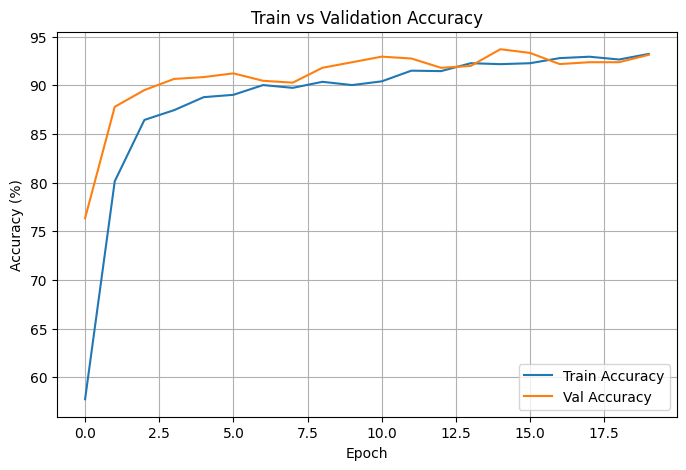

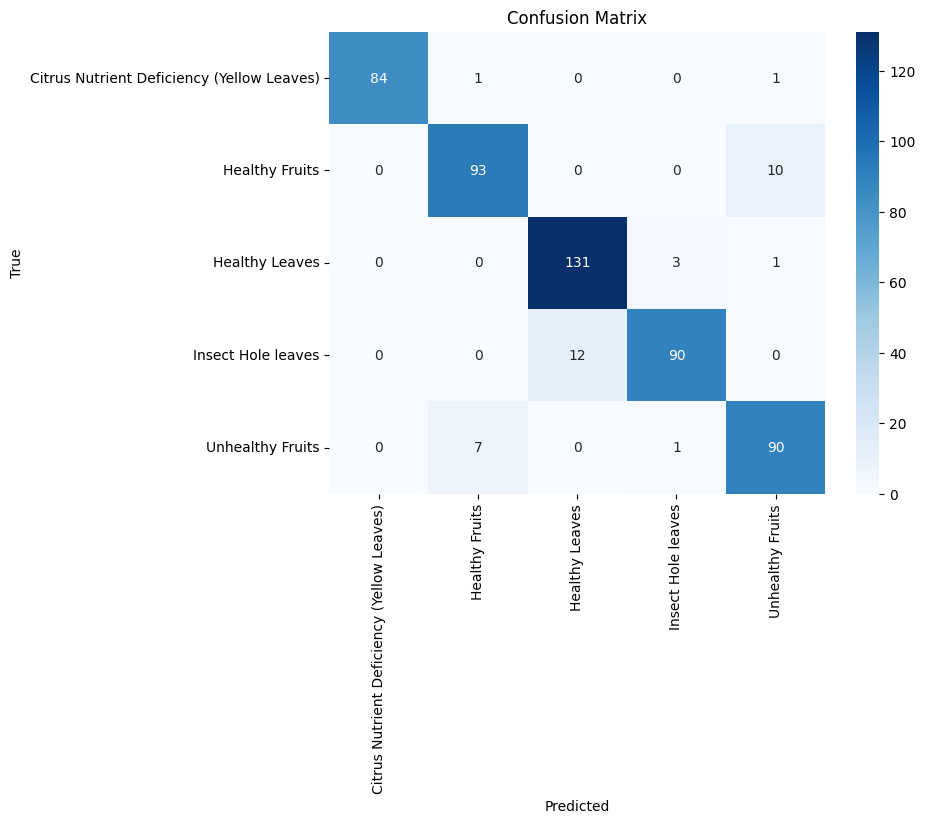


Classification Report:
                                            precision    recall  f1-score   support

Citrus Nutrient Deficiency (Yellow Leaves)       1.00      0.98      0.99        86
                            Healthy Fruits       0.92      0.90      0.91       103
                            Healthy Leaves       0.92      0.97      0.94       135
                        Insect Hole leaves       0.96      0.88      0.92       102
                          Unhealthy Fruits       0.88      0.92      0.90        98

                                  accuracy                           0.93       524
                                 macro avg       0.94      0.93      0.93       524
                              weighted avg       0.93      0.93      0.93       524



In [3]:
# ✅ Full ResNet50 Pipeline for Star Fruit Disease Classification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path
data_path = "/kaggle/input/star-fruit/Star Fruit Dataset"

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Load full dataset
dataset = datasets.ImageFolder(root=data_path, transform=train_transforms)
class_names = dataset.classes

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load ResNet50 model
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(resnet50.fc.in_features, len(class_names))
resnet50 = resnet50.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

# Training settings
num_epochs = 20
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Validation
    resnet50.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

# Save model
torch.save(resnet50.state_dict(), "resnet50_starfruit.pth")

# Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
